In [1]:
import pandas as pd
from utils.categorical_encoders import CategoricalEncoders

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score

import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

In [2]:
# 1. Leer el dataset
DATASET_PATH = 'data/dataset.csv'
dataset = pd.read_csv(DATASET_PATH, encoding='latin-1' ,sep=';')
print(dataset['Target'].value_counts())
print(dataset['Target'].value_counts(normalize=True))

Target
0    8137
1     363
Name: count, dtype: int64
Target
0    0.957294
1    0.042706
Name: proportion, dtype: float64


In [3]:
# 2. Obtener las columnas binarias y categóricas
categorical = CategoricalEncoders(dataset=dataset)
binary_columns, categorical_columns = categorical.get_binary_categorical_columns()

# 3. Aplicar categorical encoders
methods = ['LabelEncoder', 'OneHotEncoder', 'OrdinalEncoder', 'FrequencyEncoder', 'BinaryEncoder', 'BackwardDifferenceEncoder']
data_encoded = categorical.provider(binary_columns, categorical_columns, method=methods[0])

# 4. Dividir el dataset en train y test
X,y = data_encoded.drop(['Target'], axis=1),data_encoded[["Target"]]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)
print(y_train['Target'].value_counts())
print(y_test['Target'].value_counts())

Target
0    6103
1     272
Name: count, dtype: int64
Target
0    2034
1      91
Name: count, dtype: int64


In [4]:
# 5. Entrenar modelos
from utils.base_models import BaseModels

base_models = BaseModels()
name_models = ['logistic_regression', 'decision_tree', 'random_forest',
               'gradient_boosting', 'svm', 'knn', 'naive_bayes', 'mlp',
               'lgbm','catboost', 'xgboost']

model = base_models.provider(name_models[0])
model.fit(X_train, y_train)

predict_train = model.predict_proba(X_train)[:,1]
predict_test = model.predict_proba(X_test)[:,1]


print("auc on training in LogisticRegression data : {:.3f}"
      .format(roc_auc_score(y_train, predict_train) ))
print("auc on testing in LogisticRegression  data : {:.3f}"
      .format(roc_auc_score(y_test, predict_test) ))

auc on training in LogisticRegression data : 0.726
auc on testing in LogisticRegression  data : 0.711


In [5]:
results = []
for name in name_models:
    model = base_models.provider(name)
    model.fit(X_train, y_train)

    predict_train = model.predict_proba(X_train)[:, 1]
    predict_test = model.predict_proba(X_test)[:, 1]

    train_auc = roc_auc_score(y_train, predict_train)
    test_auc = roc_auc_score(y_test, predict_test)

    results.append((name, train_auc, test_auc))

    print(f"AUC on training data with {name}: {train_auc:.3f}")
    print(f"AUC on testing data with {name}: {test_auc:.3f}")

# Ordenar los resultados por test_auc de mayor a menor
results.sort(key=lambda x: x[2], reverse=False)

# Desempaquetar los resultados ordenados
sorted_names, train_aucs, test_aucs = zip(*results)

AUC on training data with logistic_regression: 0.726
AUC on testing data with logistic_regression: 0.711
AUC on training data with decision_tree: 0.988
AUC on testing data with decision_tree: 0.559
AUC on training data with random_forest: 0.984
AUC on testing data with random_forest: 0.686
AUC on training data with gradient_boosting: 0.832
AUC on testing data with gradient_boosting: 0.801
AUC on training data with svm: 0.812
AUC on testing data with svm: 0.592
AUC on training data with knn: 0.904
AUC on testing data with knn: 0.609
AUC on training data with naive_bayes: 0.709
AUC on testing data with naive_bayes: 0.697
AUC on training data with mlp: 0.836
AUC on testing data with mlp: 0.748
[LightGBM] [Info] Number of positive: 272, number of negative: 6103
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000534 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[Light

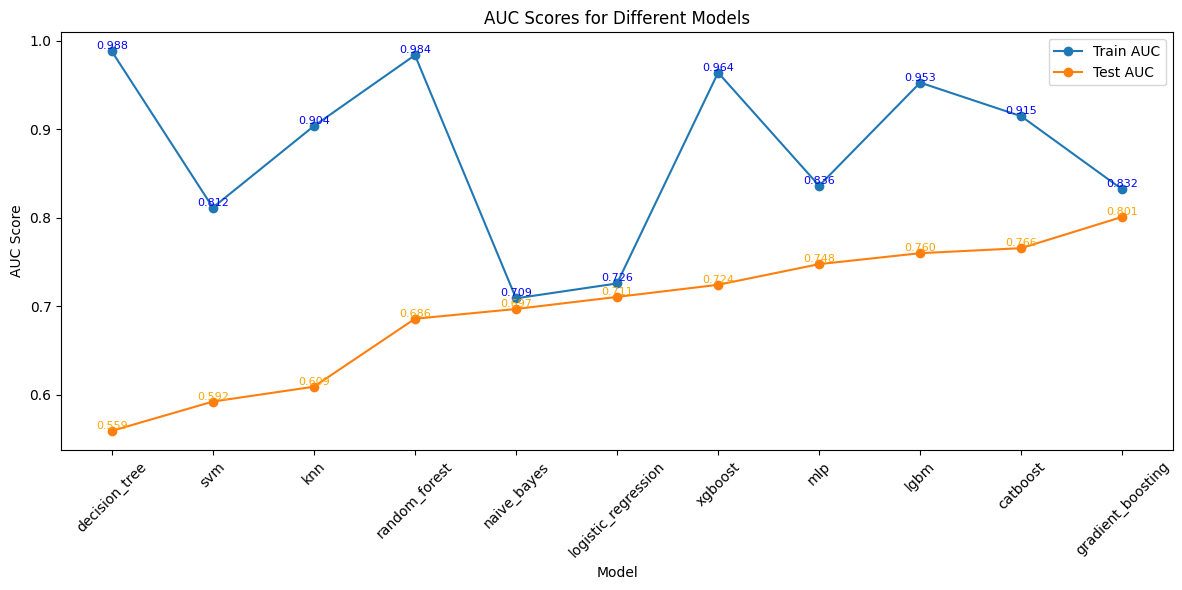

In [6]:
# Crear el plot
plt.figure(figsize=(12, 6))
plt.plot(sorted_names, train_aucs, label='Train AUC', marker='o')
plt.plot(sorted_names, test_aucs, label='Test AUC', marker='o')

# Añadir los valores numéricos en el gráfico
for i, (name, train_auc, test_auc) in enumerate(results):
    plt.text(i, train_auc, f'{train_auc:.3f}', ha='center', va='bottom', fontsize=8, color='blue')
    plt.text(i, test_auc, f'{test_auc:.3f}', ha='center', va='bottom', fontsize=8, color='orange')

plt.xticks(rotation=45)
plt.xlabel('Model')
plt.ylabel('AUC Score')
plt.title('AUC Scores for Different Models')
plt.legend()
plt.tight_layout()
plt.show()